# Dashcam Distances

Attempt to create a model for estimating distance based on a corrected image from a dashcam

In [82]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import pathlib

from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

module_path_root = os.path.abspath(os.pardir)
if module_path_root not in sys.path:
    sys.path.append(module_path_root)

## Configuration

In [2]:
# Path to directory where calibration images are saved
images_dir    = os.path.join(module_path_root, 'data_sources', 'dashcam_measurement_images')
images_format = 'png' # File format of the calibration images
config_file   = os.path.join(module_path_root, 'data_sources', 'dashcam_calibration.yml')

## Function Definitions

From: https://medium.com/vacatronics/3-ways-to-calibrate-your-camera-using-opencv-and-python-395528a51615
Adapted from C++ code at: https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html

In [3]:
def load_coefficients(path):
    '''Loads camera matrix and distortion coefficients.'''
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode('K').mat()
    dist_matrix = cv_file.getNode('D').mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

## Convert calibration video to image

In [4]:
def split_video(filename, output_dir, video_num, wanted_frame):
    cap = cv2.VideoCapture(filename)
    
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frame_num = 0
    
    while True:
        ret, frame = cap.read()
        frame_num += 1
        
        if ret == True:
            if frame_num == wanted_frame:
                filename = 'frame_{0:02d}_{1:05d}.png'.format(video_num, frame_num)
                print('Writing: {0:s}'.format(filename))
                cv2.imwrite(os.path.join(output_dir, filename), frame)
        else:
            break
    
    cap.release()       
        

In [5]:
video1 = os.path.join(images_dir, 'FILE210923-133911F.MP4')

split_video(video1, images_dir, 1, 4*60)

Writing: frame_01_00240.png


## Correct the image for distortion

In [6]:
sample_image_in  = os.path.join(images_dir, 'frame_01_00240.png')
sample_image_out = os.path.join(images_dir, 'corrected_frame_01_00240.png')

In [7]:
mtx, dist = load_coefficients(config_file)
original = cv2.imread(sample_image_in)

dst = cv2.undistort(original, mtx, dist, None, None)

cv2.imwrite(sample_image_out, dst)

True

## Draw lines on image to identify points

The calibration tool in the image changes color from black to yellow every 25cm

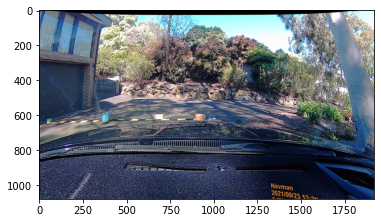

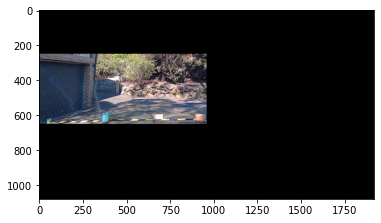

960
935
887
840
792
745
697
650
605
560
519
473
427
381
335
298
262
228
195
164
135
108
82
57


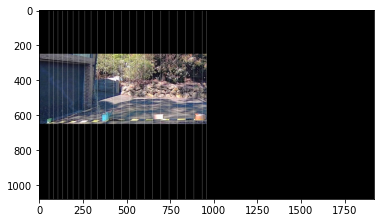

True

In [78]:
corrected_image = cv2.imread(sample_image_out)
corrected_image = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB)

height = corrected_image.shape[0]
width  = corrected_image.shape[1]

region_of_interest_vertices = [
        (0, 650), (width/2, 650), (width/2, 250), (0, 250)
]

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    channel_count = img.shape[2]
    match_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
      
cropped_image = region_of_interest(corrected_image, np.array([region_of_interest_vertices],np.int32))

plt.imshow(corrected_image)
plt.show()

plt.imshow(cropped_image)
plt.show()

cv2.imwrite(os.path.join(images_dir, 'cropped.png'), cropped_image)

xs = [0, 25, 48, 47, 48, 47, 48, 47, 45, 45, 41, 46, 46, 46, 46, 37, 36, 34, 33, 31, 29, 27, 26, 25]

x1 = 960
for x in xs:
    x1 -= x
    print(x1)
    cv2.line(cropped_image, (x1, 0), (x1, 1080), (255, 255, 255), thickness=1)

plt.imshow(cropped_image)
plt.show()

cv2.imwrite(os.path.join(images_dir, 'lines.png'), cropped_image)


In [84]:

list_x = []
list_y = []

# Manually record first two points
# Gap before the first sheet, and then the second sheet is >25cm
x = 0
y = 0.0

list_x.append(x)
list_y.append(y)

x = 25
y = 12.5

list_x.append(x)
list_y.append(y)

for idx in range(2, len(xs)):
    x += xs[idx]
    y += 25
    
    list_x.append(x)
    list_y.append(y)
    
print(list_x)
print(list_y)

# Construct pandas dataframe
df = pd.DataFrame(list(zip(list_x, list_y)), columns=['offset', 'distance'])
df

[0, 25, 73, 120, 168, 215, 263, 310, 355, 400, 441, 487, 533, 579, 625, 662, 698, 732, 765, 796, 825, 852, 878, 903]
[0.0, 12.5, 37.5, 62.5, 87.5, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5, 412.5, 437.5, 462.5, 487.5, 512.5, 537.5, 562.5]


,offset,distance
0,0,0.0
1,25,12.5
2,73,37.5
3,120,62.5
4,168,87.5
5,215,112.5
6,263,137.5
7,310,162.5
8,355,187.5
9,400,212.5


In [ ]:
# https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386
# https://www.statology.org/adjusted-r-squared-in-python/

In [93]:
from sklearn.linear_model import LinearRegression

X = df[['offset']].values
y = df['distance'].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Display adjusted R-squared
1 - (1 - lin_reg.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

0.9920644853482847

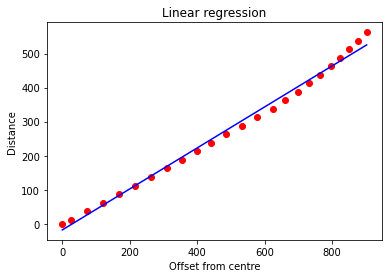

In [94]:
plt.scatter(X, y, color='red')
plt.plot(X, lin_reg.predict(X), color='blue')
plt.title('Linear regression')
plt.xlabel('Offset from centre')
plt.ylabel('Distance')
plt.show()

In [107]:
from sklearn.preprocessing import PolynomialFeatures

def fit_poly(degree):
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Polynomial regression, degree={0:d}'.format(degree))
    plt.xlabel('Offset from centre')
    plt.ylabel('Distance')
    plt.show()
    
    return pol_reg, poly_reg

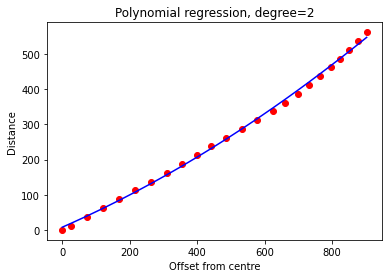

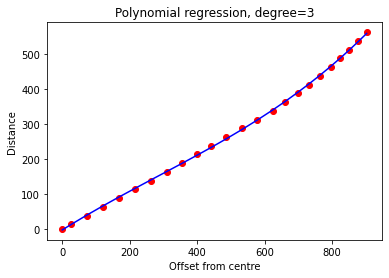

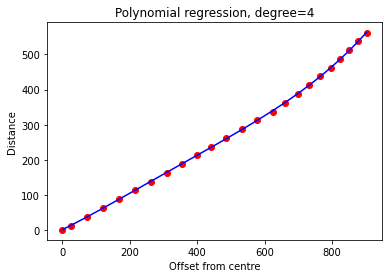

In [110]:
pol_reg2, poly_reg2 = fit_poly(2)
pol_reg3, poly_reg3 = fit_poly(3)
pol_reg4, poly_reg4 = fit_poly(4)

In [115]:
def predict(X):
    return pol_reg3.predict(poly_reg3.fit_transform([[x]]))
    
print(predict(900))

[559.14444659]


## Save the model

In [116]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

import pickle

In [118]:
model_filename_poly = os.path.join(module_path_root, 'models', 'distance_poly.csv')
model_filename_pol  = os.path.join(module_path_root, 'models', 'distance_pol.csv')

pickle.dump(poly_reg3, open(model_filename_poly, 'wb'))
pickle.dump(pol_reg3, open(model_filename_pol, 'wb'))

## Load the model

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import pickle

loaded_poly = pickle.load(open(model_filename_poly, 'rb'))
loaded_pol  = pickle.load(open(model_filename_pol,  'rb'))

def loaded_predict(X):
    return loaded_pol.predict(loaded_poly.fit_transform([[X]]))
    
print(predict(900))

[559.14444659]
